In [1]:
from tensorflow.keras import models, optimizers, losses
from utils import *
from loss import *
from network import *
from metrics import *
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib import pyplot as plt
import cv2
import pandas as pd

In [2]:
train_low, train_high, val_low, val_high, test_low = data_loader_v2('./interpolation/')
print("Train X's shape : ", train_low.shape)
print("Train Y's shape : ", train_high.shape)
print("Validation X's shape : ", val_low.shape)
print("Validation Y's shape : ", val_high.shape)
print("Test X's shape : ", test_low.shape)


Train X's shape :  (303, 320, 256, 3)
Train Y's shape :  (303, 320, 256, 6)
Validation X's shape :  (25, 320, 256, 3)
Validation Y's shape :  (25, 320, 256, 6)
Test X's shape :  (328, 320, 256, 3)


In [3]:
test_high = np.reshape(np.transpose(val_high, [1, 2, 0, 3]), [320, 256, 150])
test_low = np.transpose(val_low[...,1], [1,2,0])

print(test_high.shape)
print(test_low.shape)

(320, 256, 150)
(320, 256, 25)


In [4]:
def bilinear(img3d):
    h, w, c = img3d.shape
    axis1 = np.array([cv2.resize(img3d[i, ...], (c*6, w), interpolation=cv2.INTER_LINEAR) for i in range(h)])
    axis2 = np.array([cv2.resize(img3d[:, i, :], (c*6, h), interpolation=cv2.INTER_LINEAR) for i in range(w)])
    output = (axis1 + np.transpose(axis2, [1, 0, 2]))/2
    return output


def bicubic(img3d):
    h, w, c = img3d.shape
    axis1 = np.array([cv2.resize(img3d[i, ...], (c*6, w), interpolation=cv2.INTER_CUBIC) for i in range(h)])
    axis2 = np.array([cv2.resize(img3d[:, i, :], (c*6, h), interpolation=cv2.INTER_CUBIC) for i in range(w)])
    output = (axis1 + np.transpose(axis2, [1, 0, 2]))/2
    return output

def lanc(img3d):
    h, w, c = img3d.shape
    axis1 = np.array([cv2.resize(img3d[i, ...], (c*6, w), interpolation=cv2.INTER_LANCZOS4) for i in range(h)])
    axis2 = np.array([cv2.resize(img3d[:, i, :], (c*6, h), interpolation=cv2.INTER_LANCZOS4) for i in range(w)])
    output = (axis1 + np.transpose(axis2, [1, 0, 2]))/2
    return output

In [15]:
def orthoview(result):
    h, w, c = result[0].shape
    vmax = result[0].max()
    def _plot(axial, coronal, saggital):
        fig, ax = plt.subplots(3, 5, figsize=(20, 12))
        
        ax[0,0].set_title("Label")
        ax[0,0].set_ylabel("Axial")
        ax[0,0].imshow(result[0][..., axial], vmin=0, vmax=vmax, cmap='gray')
        #ax[0,0].axis('off')
        
        #ax[1,0].set_title("Coronal")
        ax[1,0].set_ylabel("Coronal")
        ax[1,0].imshow(np.rot90(result[0][coronal, ...], 1), vmin=0, vmax=vmax, cmap='gray')
        #ax[1,0].axis('off')
        
        #ax[2,0].set_title("Sgittal")
        ax[2,0].set_ylabel("Sagittal")
        ax[2,0].imshow(np.rot90(result[0][:,saggital,:], 1), vmin=0, vmax=vmax, cmap='gray')
        #ax[2,0].axis('off')
        
        ax[0,1].set_title("Bilinear")
        ax[0,1].imshow(result[1][..., axial], vmin=0, vmax=vmax, cmap='gray')
        ax[0,1].axis('off')
        
        #ax[1,1].set_title("Coronal")
        ax[1,1].imshow(np.rot90(result[1][coronal, ...], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[1,1].axis('off')
        
        #ax[2,1].set_title("Sagittal")
        ax[2,1].imshow(np.rot90(result[1][:,saggital,:], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[2,1].axis('off')
        
        ax[0,2].set_title("Bicubic")
        ax[0,2].imshow(result[2][..., axial], vmin=0, vmax=vmax, cmap='gray')
        ax[0,2].axis('off')
        
        #ax[1,2].set_title("Coronal")
        ax[1,2].imshow(np.rot90(result[2][coronal, ...], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[1,2].axis('off')
        
        #ax[2,2].set_title("Sagittal")
        ax[2,2].imshow(np.rot90(result[2][:,saggital,:], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[2,2].axis('off')
        
        ax[0,3].set_title("Lanczos")
        ax[0,3].imshow(result[3][..., axial], vmin=0, vmax=vmax, cmap='gray')
        ax[0,3].axis('off')
        
        #ax[1,3].set_title("Coronal")
        ax[1,3].imshow(np.rot90(result[3][coronal, ...], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[1,3].axis('off')
        
        #ax[2,3].set_title("Sagittal")
        ax[2,3].imshow(np.rot90(result[3][:,saggital,:], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[2,3].axis('off')
        
        ax[0,4].set_title("Proposed")
        ax[0,4].imshow(result[4][..., axial], vmin=0, vmax=vmax, cmap='gray')
        ax[0,4].axis('off')
        
        #ax[1,3].set_title("Coronal")
        ax[1,4].imshow(np.rot90(result[4][coronal, ...], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[1,4].axis('off')
        
        #ax[2,3].set_title("Sagittal")
        ax[2,4].imshow(np.rot90(result[4][:,saggital,:], 1), vmin=0, vmax=vmax, cmap='gray')
        ax[2,4].axis('off')
        
        fig.tight_layout()
    interact(_plot, axial=(0,c-1,1), coronal=(0,h-1,1), saggital=(0,w-1,1), )

In [6]:
root_path = './checkpoint/3to6/unet_l2_mi/'

model_path = root_path+'model.json'
train_csv_path = root_path+'train_loss.csv'
val_csv_path = root_path+'val_loss.csv'

weights_list = sorted(os.listdir(root_path))
weights_list = [i for i in weights_list if '.h5' in i]

with open(model_path, 'r') as f:
    model_json = f.read()

A = models.model_from_json(model_json)

A.load_weights(root_path+weights_list[-1])


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
train_, _ = A.predict(train_low)
val_, _ = A.predict(val_low)
print(train_.shape)
print(val_.shape)

(303, 320, 256, 6)
(25, 320, 256, 6)


In [8]:
val_4vis = np.reshape(np.transpose(val_, [1, 2, 0, 3]), [320, 256, 150])

In [17]:
bil = bilinear(test_low)
bic = bicubic(test_low)
lan = lanc(test_low)

In [18]:
print(bil.shape)
print(bic.shape)
print(lan.shape)

(320, 256, 150)
(320, 256, 150)
(320, 256, 150)


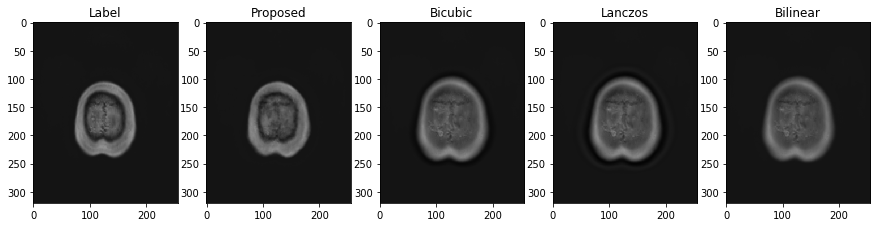

In [34]:
for i in range(bil.shape[-1]):
    clear_output(wait=True)
    vmin = min([test_high.min(), bil.min(), bic.min(), lan.min(), val_4vis.min()])
    vmax = max([test_high.max(), bil.max(), bic.max(), lan.max(), val_4vis.max()])
    plt.figure(figsize=(15, 5))
    
    plt.subplot(151)
    plt.title("Label")
    plt.imshow(test_high[...,i], cmap='gray', vmin=vmin, vmax=vmax)
    #plt.imshow(np.rot90(test_high[...,i], 1), cmap='gray', vmin=vmin, vmax=vmax)
    
    plt.subplot(152)
    plt.title("Proposed")
    plt.imshow(val_4vis[...,i], cmap='gray', vmin=vmin, vmax=vmax)
    #plt.imshow(np.rot90(val_4vis[...,i], 1), cmap='gray', vmin=vmin, vmax=vmax)
    
    plt.subplot(153)
    plt.title("Bicubic")
    plt.imshow(bic[...,i], cmap='gray', vmin=vmin, vmax=vmax)
    #plt.imshow(np.rot90(bic[...,i], 1), cmap='gray', vmin=vmin, vmax=vmax)
    
    plt.subplot(154)
    plt.title("Lanczos")
    plt.imshow(lan[...,i], cmap='gray', vmin=vmin, vmax=vmax)
    #plt.imshow(np.rot90(lan[...,i], 1), cmap='gray', vmin=vmin, vmax=vmax)
    
    plt.subplot(155)
    plt.title("Bilinear")
    plt.imshow(bil[...,i], cmap='gray', vmin=vmin, vmax=vmax)
    #plt.imshow(np.rot90(bil[...,i], 1), cmap='gray', vmin=vmin, vmax=vmax)
    
    plt.savefig('./figure/Result/Axial/%03d.png'%i)
    plt.show()
    

In [16]:
orthoview([test_high, bilinear(test_low), bicubic(test_low), lanc(test_low), val_4vis])

interactive(children=(IntSlider(value=74, description='axial', max=149), IntSlider(value=159, description='cor…